SIN HACER!!!!!!!!!!

In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import SGD, AdamW
from torch import nn

from sklearn.feature_extraction.text import TfidfVectorizer
from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import logistic_regresion as lr
import singletask_dep as st
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoding_type = 'pos'

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']

vocab_dep = st.Vocabulary(data['train'],encoding_type)

vectorizer = TfidfVectorizer()

vectorizer.fit_transform(list(convai_train.keys()))

convai_train_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_train,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 
convai_val_token = generic.tokenize_dataset_with_dependencies_rrnn2(convai_val,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 

In [6]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False,tfidf=True,deps=True)

In [7]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False,tfidf=True,deps=True)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies_rrnn2(md_data,['about','to','as'],vocab=vocab_dep,tfidf=vectorizer) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True,tfidf=True,deps=True)

# Creación dataloaders

In [10]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [11]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn_dep)

In [12]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn_dep)

# ABOUT

In [13]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [14]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep)

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6804644153923939 	 Validation loss: 0.679529644675174 	 
  1%|          | 574/57400 [00:13<20:05, 47.14it/s]
Epoch 2 	 Training loss: 0.6710870629403649 	 Validation loss: 0.6670566514386969 	 
  2%|▏         | 1148/57400 [00:23<14:30, 64.60it/s]
Epoch 3 	 Training loss: 0.6634303177690672 	 Validation loss: 0.6620938979973228 	 
  3%|▎         | 1722/57400 [00:33<14:21, 64.67it/s]
Epoch 4 	 Training loss: 0.658998922188523 	 Validation loss: 0.6586477120043868 	 
  4%|▍         | 2296/57400 [00:42<14:18, 64.20it/s]
Epoch 5 	 Training loss: 0.655587214106882 	 Validation loss: 0.6555188480070082 	 
  5%|▌         | 2870/57400 [00:52<13:50, 65.69it/s]
Epoch 6 	 Training loss: 0.6526729563179747 	 Validation loss: 0.6531896217394684 	 
  6%|▌         | 3444/57400 [01:01<14:01, 64.15it/s]
Epoch 7 	 Training loss: 0.6497143420815883 	 Validation loss: 0.6503631997916658 	 
  7%|▋         | 4018/57400 [01:11<13:49, 64.34it/s]
Epoch 8 	 Training loss: 0.64718720140

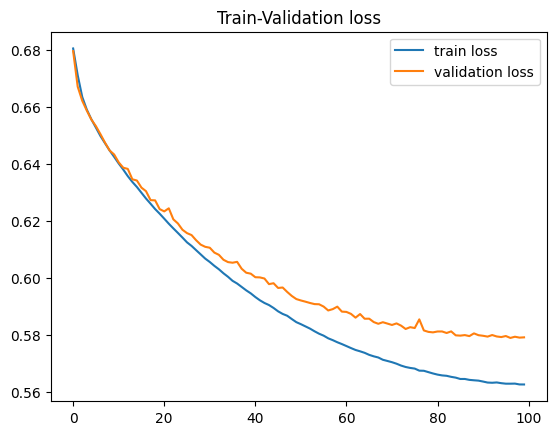

In [15]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about1'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5841836734693877, 'precision': 0.5841836734693877, 'f1': 0.5841836734693877, 'accuracy': 0.5841836734693877}
MALE {'recall': 0.8567708333333334, 'precision': 0.8567708333333334, 'f1': 0.8567708333333334, 'accuracy': 0.8567708333333334}
FEMALE {'recall': 0.3225, 'precision': 0.3225, 'f1': 0.3225, 'accuracy': 0.3225} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}
MALE {'recall': 0.8126520681265207, 'precision': 0.8126520681265207, 'f1': 0.8126520681265208, 'accuracy': 0.8126520681265207}
FEMALE {'recall': 0.2572178477690289, 'precision': 0.2572178477690289, 'f1': 0.2572178477690289, 'accuracy': 0.2572178477690289} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5345501955671447, 'precision': 0.5345501955671447, 'f1': 0.5345501955671447, 'accuracy': 0.5345501955671447}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6800289687794675 	 Validation loss: 0.6776388136007018 	 
  1%|          | 574/57400 [00:09<14:14, 66.53it/s]
Epoch 2 	 Training loss: 0.6700753403457615 	 Validation loss: 0.66959082373118 	 
  2%|▏         | 1148/57400 [00:19<14:06, 66.47it/s]
Epoch 3 	 Training loss: 0.6645717077761992 	 Validation loss: 0.6639378575955407 	 
  3%|▎         | 1722/57400 [00:28<14:03, 65.98it/s]
Epoch 4 	 Training loss: 0.661150504591573 	 Validation loss: 0.6608465202784134 	 
  4%|▍         | 2296/57400 [00:38<13:55, 65.96it/s]
Epoch 5 	 Training loss: 0.6575956770351955 	 Validation loss: 0.6572595955961842 	 
  5%|▌         | 2870/57400 [00:48<13:37, 66.72it/s]
Epoch 6 	 Training loss: 0.6542042268485557 	 Validation loss: 0.6553585014100802 	 
  6%|▌         | 3444/57400 [00:57<13:43, 65.56it/s]
Epoch 7 	 Training loss: 0.6512439246792411 	 Validation loss: 0.6518011668981132 	 
  7%|▋         | 4018/57400 [01:07<13:34, 65.50it/s]
Epoch 8 	 Training loss: 0.64830292797

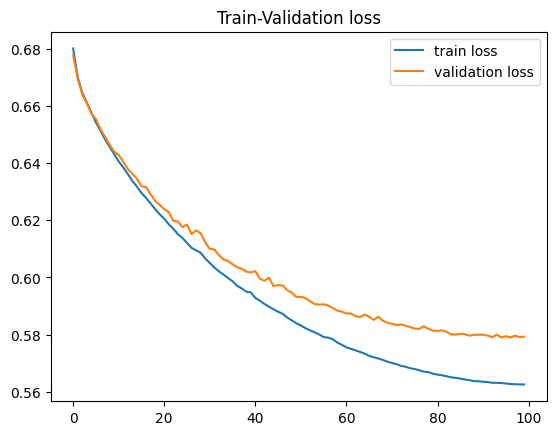

In [17]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about2'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5803571428571429, 'precision': 0.5803571428571429, 'f1': 0.5803571428571429, 'accuracy': 0.5803571428571429}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.305, 'precision': 0.305, 'f1': 0.305, 'accuracy': 0.305} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5707070707070707, 'precision': 0.5707070707070707, 'f1': 0.5707070707070707, 'accuracy': 0.5707070707070707}
MALE {'recall': 0.8540145985401459, 'precision': 0.8540145985401459, 'f1': 0.8540145985401459, 'accuracy': 0.8540145985401459}
FEMALE {'recall': 0.2650918635170604, 'precision': 0.2650918635170604, 'f1': 0.2650918635170604, 'accuracy': 0.2650918635170604} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5423728813559322, 'precision': 0.5423728813559322, 'f1': 0.5423728813559322, 'accuracy': 0.5423728813559322}
MALE {'recall': 0.803030303030303, 'precision': 0.803030

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6800610170754822 	 Validation loss: 0.6795477250875053 	 
  1%|          | 574/57400 [00:09<14:22, 65.88it/s]
Epoch 2 	 Training loss: 0.6702218821032122 	 Validation loss: 0.6671409394781468 	 
  2%|▏         | 1148/57400 [00:18<13:52, 67.56it/s]
Epoch 3 	 Training loss: 0.6634317141169039 	 Validation loss: 0.6630354786323289 	 
  3%|▎         | 1722/57400 [00:28<13:49, 67.08it/s]
Epoch 4 	 Training loss: 0.6591204189880384 	 Validation loss: 0.6589677515676466 	 
  4%|▍         | 2296/57400 [00:37<13:48, 66.55it/s]
Epoch 5 	 Training loss: 0.6560305449397722 	 Validation loss: 0.6565768991486501 	 
  5%|▌         | 2870/57400 [00:47<13:44, 66.13it/s]
Epoch 6 	 Training loss: 0.6531694879307565 	 Validation loss: 0.6536295828172716 	 
  6%|▌         | 3444/57400 [00:57<13:40, 65.74it/s]
Epoch 7 	 Training loss: 0.6504700996942221 	 Validation loss: 0.6512431754904279 	 
  7%|▋         | 4018/57400 [01:06<13:28, 66.04it/s]
Epoch 8 	 Training loss: 0.64809991

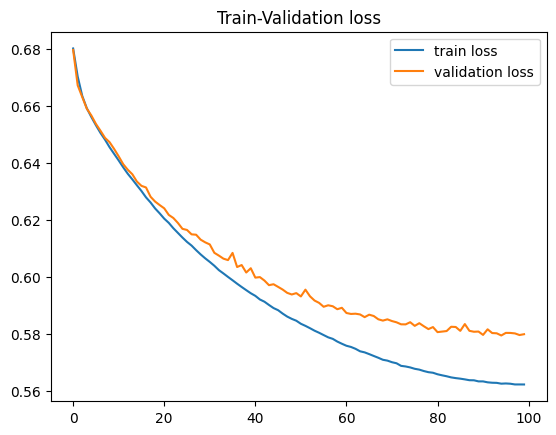

In [19]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_about3'
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5880102040816326, 'precision': 0.5880102040816326, 'f1': 0.5880102040816326, 'accuracy': 0.5880102040816326}
MALE {'recall': 0.8671875, 'precision': 0.8671875, 'f1': 0.8671875, 'accuracy': 0.8671875}
FEMALE {'recall': 0.32, 'precision': 0.32, 'f1': 0.32, 'accuracy': 0.32} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5429292929292929, 'precision': 0.5429292929292929, 'f1': 0.5429292929292929, 'accuracy': 0.5429292929292929}
MALE {'recall': 0.8223844282238443, 'precision': 0.8223844282238443, 'f1': 0.8223844282238444, 'accuracy': 0.8223844282238443}
FEMALE {'recall': 0.24146981627296588, 'precision': 0.24146981627296588, 'f1': 0.24146981627296588, 'accuracy': 0.24146981627296588} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5358539765319427, 'precision': 0.5358539765319427, 'f1': 0.5358539765319427, 'accuracy': 0.5358539765319427}
MALE {'recall': 0.7752525252525253, 'precision': 0.77525

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5841836734693877, 'precision': 0.5841836734693877, 'f1': 0.5841836734693877, 'accuracy': 0.5841836734693877}
Métricas etiqueta male: {'recall': 0.8637152777777778, 'precision': 0.8637152777777778, 'f1': 0.8637152777777778, 'accuracy': 0.8637152777777778}
Métricas etiqueta female:  {'recall': 0.31583333333333335, 'precision': 0.31583333333333335, 'f1': 0.31583333333333335, 'accuracy': 0.31583333333333335}

 to
Resultado global: {'recall': 0.553030303030303, 'precision': 0.553030303030303, 'f1': 0.553030303030303, 'accuracy': 0.553030303030303}
Métricas etiqueta male: {'recall': 0.829683698296837, 'precision': 0.829683698296837, 'f1': 0.8296836982968371, 'accuracy': 0.829683698296837}
Métricas etiqueta female:  {'recall': 0.2545931758530184, 'precision': 0.2545931758530184, 'f1': 0.2545931758530184, 'accuracy': 0.2545931758530184}

 as
Resultado global: {'recall': 0.5375923511516731, 'precision': 0.5375923511516731, 'f1': 0.5375

# TO

In [22]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931681656879 	 Validation loss: 0.6934672038433916 	 
  1%|          | 574/57400 [00:10<15:55, 59.50it/s]
Epoch 2 	 Training loss: 0.693083219100374 	 Validation loss: 0.6933045154910976 	 
  2%|▏         | 1148/57400 [00:21<19:33, 47.92it/s]
Epoch 3 	 Training loss: 0.6929922839075016 	 Validation loss: 0.6938314670223301 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:32<15:37, 59.36it/s]
Epoch 4 	 Training loss: 0.6928915184133975 	 Validation loss: 0.6926944760952966 	 
  4%|▍         | 2296/57400 [00:42<15:10, 60.55it/s]
Epoch 5 	 Training loss: 0.6928668028386212 	 Validation loss: 0.6930228825342857 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [00:53<14:49, 61.32it/s]
Epoch 6 	 Training loss: 0.6928110340746437 	 Validation loss: 0.6929499486745414 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [01:03<14:14, 63.15it/s]
Epoch 7 	 Training loss: 0.6926909152431355 	 Validation loss: 0.6932307441355818 	 

3 ep

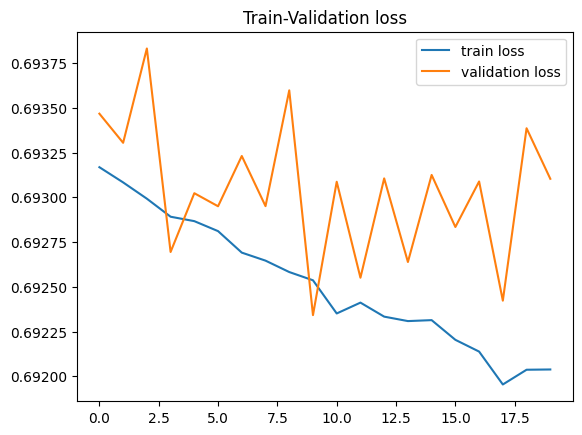

In [23]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to1'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [24]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5191326530612245, 'precision': 0.5191326530612245, 'f1': 0.5191326530612245, 'accuracy': 0.5191326530612245}
MALE {'recall': 0.17447916666666666, 'precision': 0.17447916666666666, 'f1': 0.17447916666666666, 'accuracy': 0.17447916666666666}
FEMALE {'recall': 0.85, 'precision': 0.85, 'f1': 0.85, 'accuracy': 0.85} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5227272727272727, 'precision': 0.5227272727272727, 'f1': 0.5227272727272727, 'accuracy': 0.5227272727272727}
MALE {'recall': 0.21654501216545013, 'precision': 0.21654501216545013, 'f1': 0.21654501216545013, 'accuracy': 0.21654501216545013}
FEMALE {'recall': 0.8530183727034121, 'precision': 0.8530183727034121, 'f1': 0.8530183727034121, 'accuracy': 0.8530183727034121} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5045632333767927, 'precision': 0.5045632333767927, 'f1': 0.5045632333767927, 'accuracy': 0.5045632333767927}
MALE {'recall': 

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931401788149977 	 Validation loss: 0.693335318969468 	 
  1%|          | 574/57400 [00:10<15:26, 61.31it/s]
Epoch 2 	 Training loss: 0.6930663501551758 	 Validation loss: 0.6930411094326084 	 
  2%|▏         | 1148/57400 [00:21<16:13, 57.78it/s]
Epoch 3 	 Training loss: 0.6929649604737551 	 Validation loss: 0.6926426139928527 	 
  3%|▎         | 1722/57400 [00:31<15:36, 59.44it/s]
Epoch 4 	 Training loss: 0.6929111745507044 	 Validation loss: 0.6930211408663605 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:42<15:16, 60.15it/s]
Epoch 5 	 Training loss: 0.6927525493533769 	 Validation loss: 0.6932755749104387 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:52<16:20, 55.60it/s]
Epoch 6 	 Training loss: 0.6927969180540756 	 Validation loss: 0.6923002499645039 	 
  6%|▌         | 3444/57400 [01:03<14:51, 60.52it/s]
Epoch 7 	 Training loss: 0.6927923225774998 	 Validation loss: 0.6927157499022403 	 

1 epoch without improvement
  

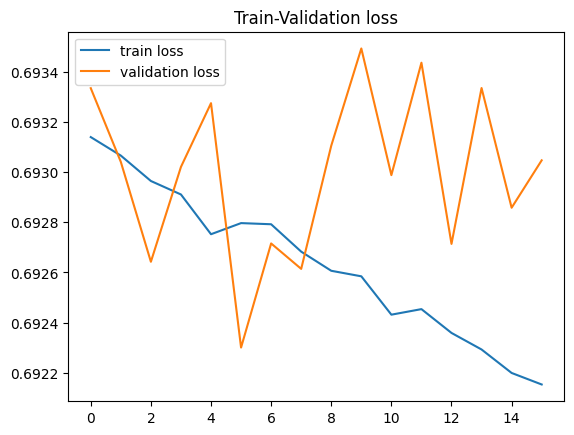

In [25]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to2'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5191326530612245, 'precision': 0.5191326530612245, 'f1': 0.5191326530612245, 'accuracy': 0.5191326530612245}
MALE {'recall': 0.078125, 'precision': 0.078125, 'f1': 0.078125, 'accuracy': 0.078125}
FEMALE {'recall': 0.9425, 'precision': 0.9425, 'f1': 0.9425, 'accuracy': 0.9425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5050505050505051, 'precision': 0.5050505050505051, 'f1': 0.5050505050505051, 'accuracy': 0.5050505050505051}
MALE {'recall': 0.09245742092457421, 'precision': 0.09245742092457421, 'f1': 0.09245742092457421, 'accuracy': 0.09245742092457421}
FEMALE {'recall': 0.9501312335958005, 'precision': 0.9501312335958005, 'f1': 0.9501312335958005, 'accuracy': 0.9501312335958005} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE {'recall': 0.05303030303030303, 'precision'

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931950443713092 	 Validation loss: 0.6933911584191403 	 
  1%|          | 574/57400 [00:10<15:56, 59.41it/s]
Epoch 2 	 Training loss: 0.6930285955970711 	 Validation loss: 0.6927061899233673 	 
  2%|▏         | 1148/57400 [00:21<17:09, 54.65it/s]
Epoch 3 	 Training loss: 0.6929680337473906 	 Validation loss: 0.6927393917310036 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:31<15:53, 58.39it/s]
Epoch 4 	 Training loss: 0.6929112753801645 	 Validation loss: 0.6931291273084738 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:42<15:06, 60.77it/s]
Epoch 5 	 Training loss: 0.6927312252205838 	 Validation loss: 0.6927464452840514 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:53<15:26, 58.84it/s]
Epoch 6 	 Training loss: 0.6927862532878172 	 Validation loss: 0.6931103063841998 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [01:05<16:47, 53.54it/s]
Epoch 7 	 Training loss: 0.692677664528325 	 Validation l

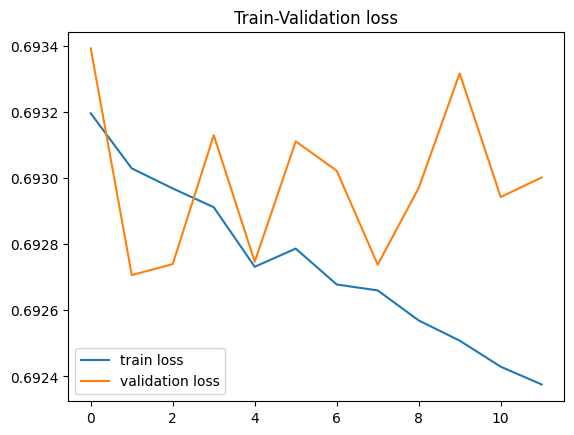

In [27]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_to3'
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5051020408163265, 'precision': 0.5051020408163265, 'f1': 0.5051020408163265, 'accuracy': 0.5051020408163265}
MALE {'recall': 0.12239583333333333, 'precision': 0.12239583333333333, 'f1': 0.12239583333333333, 'accuracy': 0.12239583333333333}
FEMALE {'recall': 0.8725, 'precision': 0.8725, 'f1': 0.8725, 'accuracy': 0.8725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48484848484848486, 'precision': 0.48484848484848486, 'f1': 0.48484848484848486, 'accuracy': 0.48484848484848486}
MALE {'recall': 0.1386861313868613, 'precision': 0.1386861313868613, 'f1': 0.1386861313868613, 'accuracy': 0.1386861313868613}
FEMALE {'recall': 0.8582677165354331, 'precision': 0.8582677165354331, 'f1': 0.8582677165354331, 'accuracy': 0.8582677165354331} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48891786179921776, 'precision': 0.48891786179921776, 'f1': 0.48891786179921776, 'accuracy': 0.48891786179921776}
MALE

In [29]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5144557823129251, 'precision': 0.5144557823129251, 'f1': 0.5144557823129251, 'accuracy': 0.5144557823129251}
Métricas etiqueta male: {'recall': 0.125, 'precision': 0.125, 'f1': 0.125, 'accuracy': 0.125}
Métricas etiqueta female:  {'recall': 0.8883333333333333, 'precision': 0.8883333333333333, 'f1': 0.8883333333333333, 'accuracy': 0.8883333333333333}

 to
Resultado global: {'recall': 0.5042087542087542, 'precision': 0.5042087542087542, 'f1': 0.5042087542087542, 'accuracy': 0.5042087542087542}
Métricas etiqueta male: {'recall': 0.1492295214922952, 'precision': 0.1492295214922952, 'f1': 0.1492295214922952, 'accuracy': 0.1492295214922952}
Métricas etiqueta female:  {'recall': 0.8871391076115486, 'precision': 0.8871391076115486, 'f1': 0.8871391076115486, 'accuracy': 0.8871391076115486}

 as
Resultado global: {'recall': 0.4941329856584094, 'precision': 0.4941329856584094, 'f1': 0.4941329856584094, 'accuracy': 0.4941329856584094}
Mét

# AS

In [30]:
max_sequence_len = 15088
learning_rate = 5e-5
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931123654601465 	 Validation loss: 0.6932071942394062 	 
  1%|          | 574/57400 [00:10<16:07, 58.75it/s]
Epoch 2 	 Training loss: 0.6929626956010945 	 Validation loss: 0.6929418687093056 	 
  2%|▏         | 1148/57400 [00:21<15:58, 58.66it/s]
Epoch 3 	 Training loss: 0.6927220361365674 	 Validation loss: 0.6931116237478742 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:31<15:04, 61.54it/s]
Epoch 4 	 Training loss: 0.6925738136112067 	 Validation loss: 0.6931906716298248 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:42<14:59, 61.27it/s]
Epoch 5 	 Training loss: 0.6924148666111019 	 Validation loss: 0.692570513587887 	 
  5%|▌         | 2870/57400 [00:52<15:00, 60.58it/s]
Epoch 6 	 Training loss: 0.6921519151132697 	 Validation loss: 0.6924267593076674 	 
  6%|▌         | 3444/57400 [01:03<14:32, 61.87it/s]
Epoch 7 	 Training loss: 0.6920180459886478 	 Validation loss: 0.6923554014351408 	 
  7%|▋         | 4018/57400 [01

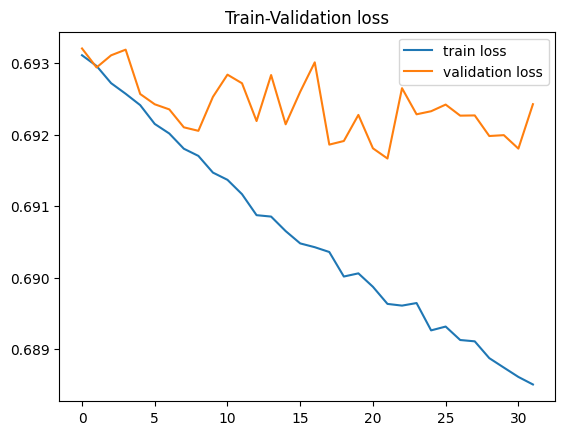

In [31]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as1'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [32]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.3697916666666667, 'precision': 0.3697916666666667, 'f1': 0.3697916666666667, 'accuracy': 0.3697916666666667}
FEMALE {'recall': 0.625, 'precision': 0.625, 'f1': 0.625, 'accuracy': 0.625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5694444444444444, 'precision': 0.5694444444444444, 'f1': 0.5694444444444444, 'accuracy': 0.5694444444444444}
MALE {'recall': 0.45255474452554745, 'precision': 0.45255474452554745, 'f1': 0.45255474452554745, 'accuracy': 0.45255474452554745}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5580182529335072, 'precision': 0.5580182529335072, 'f1': 0.5580182529335072, 'accuracy': 0.5580182529335072}
MALE {'recall': 0.4090909090909091, 'precision': 0.4090909090909091, 'f1': 0

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931083468194622 	 Validation loss: 0.6931840110633333 	 
  1%|          | 574/57400 [00:10<15:40, 60.42it/s]
Epoch 2 	 Training loss: 0.6929165548563835 	 Validation loss: 0.6928934929734569 	 
  2%|▏         | 1148/57400 [00:20<15:37, 59.97it/s]
Epoch 3 	 Training loss: 0.6927485913557458 	 Validation loss: 0.6926625340671863 	 
  3%|▎         | 1722/57400 [00:31<16:12, 57.26it/s]
Epoch 4 	 Training loss: 0.6925686052659663 	 Validation loss: 0.6930621195647676 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:42<15:30, 59.22it/s]
Epoch 5 	 Training loss: 0.6923462660262809 	 Validation loss: 0.6929816007614136 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:52<14:50, 61.26it/s]
Epoch 6 	 Training loss: 0.6921471902510015 	 Validation loss: 0.6928647493912001 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [01:03<15:30, 58.02it/s]
Epoch 7 	 Training loss: 0.6919575783226133 	 Validation loss: 0.692280846127009 	 
  

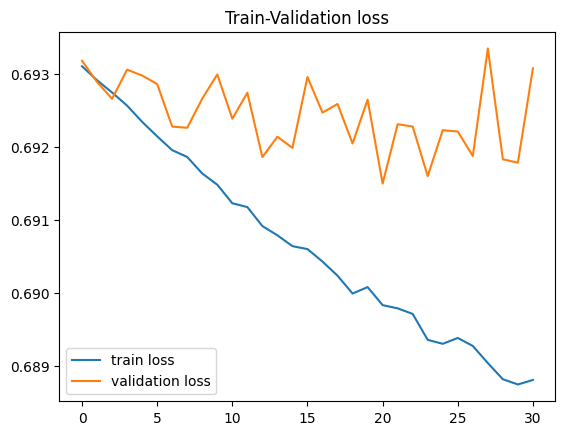

In [33]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as2'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.48596938775510207, 'precision': 0.48596938775510207, 'f1': 0.48596938775510207, 'accuracy': 0.48596938775510207}
MALE {'recall': 0.5026041666666666, 'precision': 0.5026041666666666, 'f1': 0.5026041666666666, 'accuracy': 0.5026041666666666}
FEMALE {'recall': 0.47, 'precision': 0.47, 'f1': 0.47, 'accuracy': 0.47} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5618686868686869, 'precision': 0.5618686868686869, 'f1': 0.5618686868686869, 'accuracy': 0.5618686868686869}
MALE {'recall': 0.5815085158150851, 'precision': 0.5815085158150851, 'f1': 0.5815085158150851, 'accuracy': 0.5815085158150851}
FEMALE {'recall': 0.5406824146981627, 'precision': 0.5406824146981627, 'f1': 0.5406824146981627, 'accuracy': 0.5406824146981627} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5697522816166884, 'precision': 0.5697522816166884, 'f1': 0.5697522816166884, 'accuracy': 0.5697522816166884}
MALE {'recall': 0.51

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6931252698657404 	 Validation loss: 0.692865304017471 	 
  1%|          | 574/57400 [00:10<15:47, 59.95it/s]
Epoch 2 	 Training loss: 0.6929310057636753 	 Validation loss: 0.6928236413810213 	 
  2%|▏         | 1148/57400 [00:21<15:50, 59.19it/s]
Epoch 3 	 Training loss: 0.6927520292145866 	 Validation loss: 0.6922618443683043 	 
  3%|▎         | 1722/57400 [00:31<15:04, 61.59it/s]
Epoch 4 	 Training loss: 0.6925682923935016 	 Validation loss: 0.6931945974543944 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:42<15:08, 60.63it/s]
Epoch 5 	 Training loss: 0.6923851474652307 	 Validation loss: 0.6927703356338759 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [00:52<15:22, 59.13it/s]
Epoch 6 	 Training loss: 0.6922193002410051 	 Validation loss: 0.6928112678608652 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [01:03<15:44, 57.15it/s]
Epoch 7 	 Training loss: 0.6919890496788955 	 Validation loss: 0.6925082964412237 	 

4

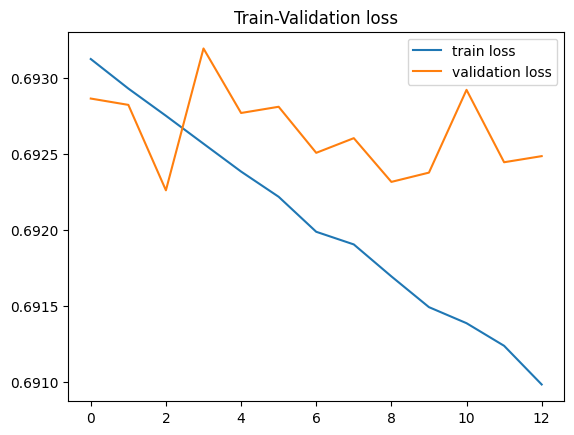

In [35]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)


save_path=f'm1_{encoding_type}_lr_as3'
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = lr.LogisticRegressionDep(sequence_max_len=max_sequence_len,lstm_hidden_dim=128,dep_vocab=vocab_dep).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5153061224489796, 'precision': 0.5153061224489796, 'f1': 0.5153061224489796, 'accuracy': 0.5153061224489796}
MALE {'recall': 0.03125, 'precision': 0.03125, 'f1': 0.03125, 'accuracy': 0.03125}
FEMALE {'recall': 0.98, 'precision': 0.98, 'f1': 0.98, 'accuracy': 0.98} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.48358585858585856, 'precision': 0.48358585858585856, 'f1': 0.48358585858585856, 'accuracy': 0.48358585858585856}
MALE {'recall': 0.0267639902676399, 'precision': 0.0267639902676399, 'f1': 0.0267639902676399, 'accuracy': 0.0267639902676399}
FEMALE {'recall': 0.9763779527559056, 'precision': 0.9763779527559056, 'f1': 0.9763779527559056, 'accuracy': 0.9763779527559056} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.485006518904824, 'precision': 0.485006518904824, 'f1': 0.485006518904824, 'accuracy': 0.485006518904824}
MALE {'recall': 0.012626262626262626, 'precision': 0.012626262626262

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5004251700680272, 'precision': 0.5004251700680272, 'f1': 0.5004251700680272, 'accuracy': 0.5004251700680272}
Métricas etiqueta male: {'recall': 0.3012152777777778, 'precision': 0.3012152777777778, 'f1': 0.3012152777777778, 'accuracy': 0.3012152777777778}
Métricas etiqueta female:  {'recall': 0.6916666666666667, 'precision': 0.6916666666666667, 'f1': 0.6916666666666667, 'accuracy': 0.6916666666666667}

 to
Resultado global: {'recall': 0.5382996632996633, 'precision': 0.5382996632996633, 'f1': 0.5382996632996633, 'accuracy': 0.5382996632996633}
Métricas etiqueta male: {'recall': 0.35360908353609083, 'precision': 0.35360908353609083, 'f1': 0.35360908353609083, 'accuracy': 0.35360908353609083}
Métricas etiqueta female:  {'recall': 0.7375328083989501, 'precision': 0.7375328083989501, 'f1': 0.7375328083989501, 'accuracy': 0.7375328083989501}

 as
Resultado global: {'recall': 0.5375923511516731, 'precision': 0.5375923511516731, 'f1':